4.297933720092603
4.297882536181813


(2.0, 5.5)

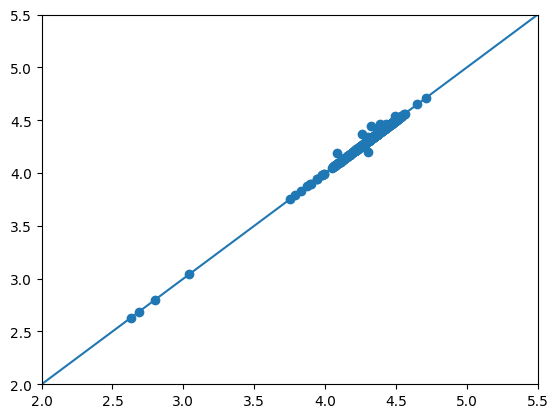

In [48]:

wavs = np.load("waves.npy")
new = []
old = np.load("entropy.npy")

for i in range(500):
    new.append(entropy(wavs[i,:]))
    
print(np.load("entropy.npy")[0])
print(entropy(wavs[0,:]))

import matplotlib.pyplot as plt
plt.scatter(old[:500],new)
plt.plot([0,6],[0,6])
plt.xlim(2,5.5); plt.ylim(2,5.5)

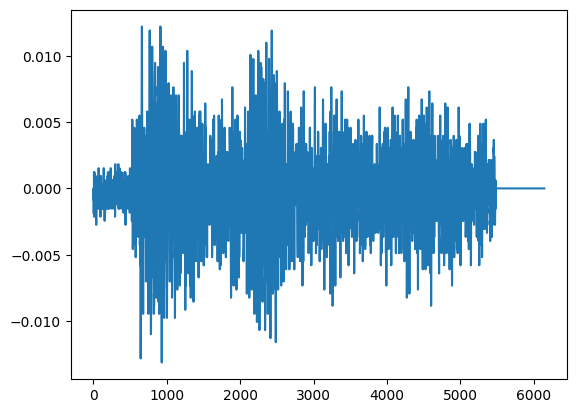

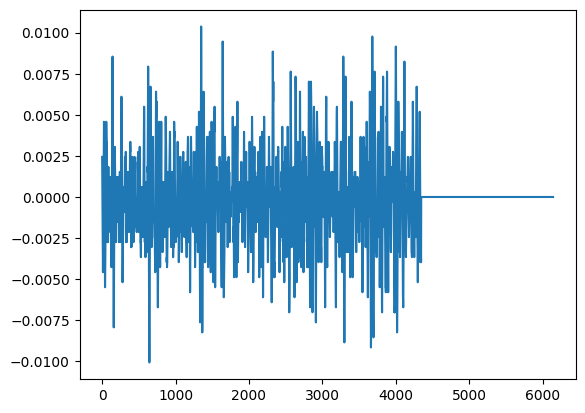

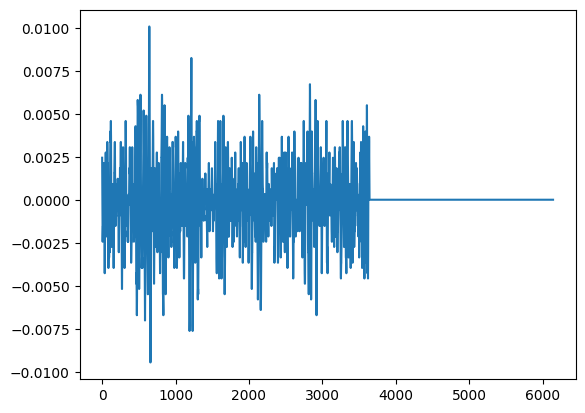

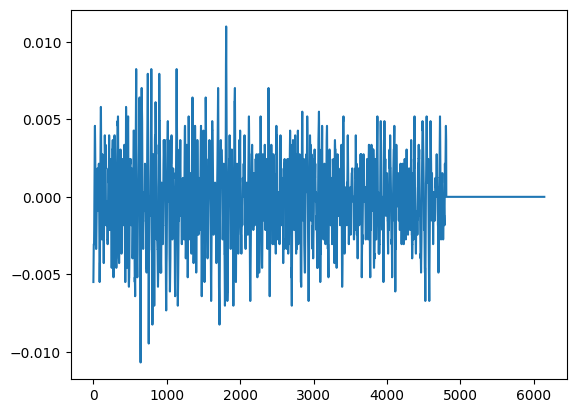

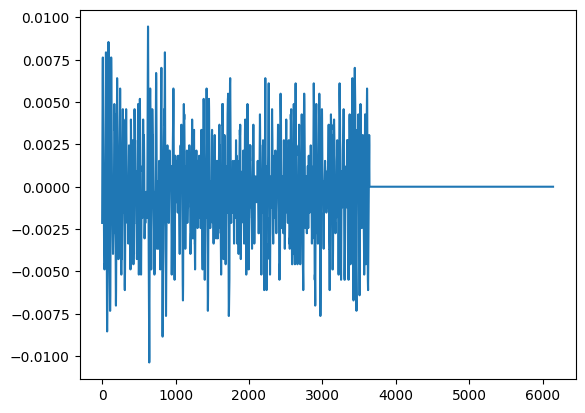

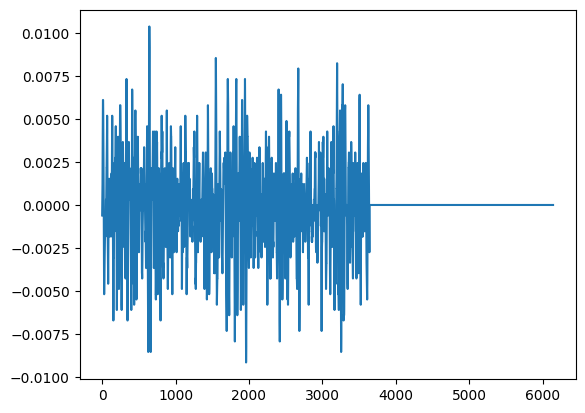

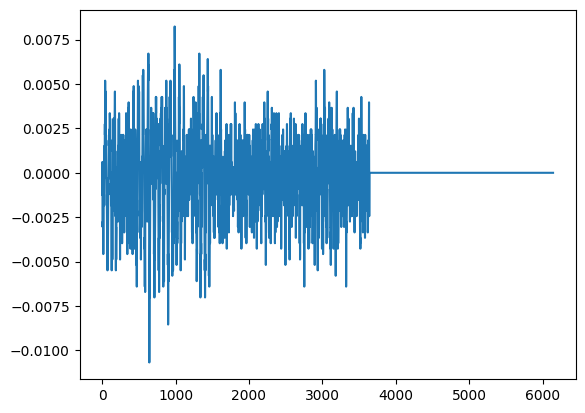

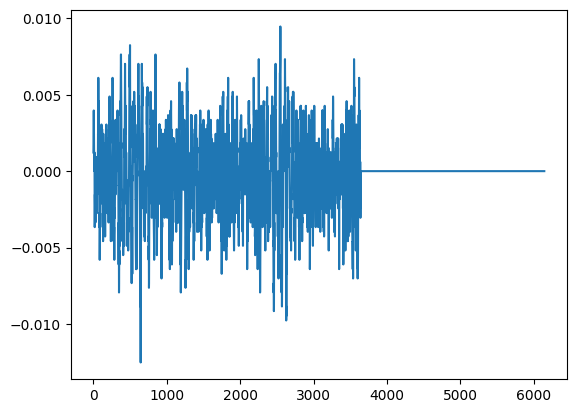

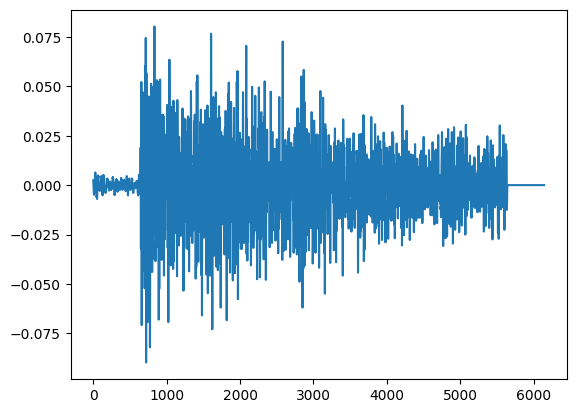

In [ ]:

import matplotlib.pyplot as plt
for i in range(0,ab.shape[0],9000):
    plt.plot(wavs[i])
    plt.show()


In [24]:
e = []
for i, w in enumerate(wav2):
    e.append(entropy(w))
    if i==0:
        print(i, e[-1])

NameError: name 'wav2' is not defined

In [ ]:
e = np.load("entropy.npy")

In [ ]:
#a = [len(w) for w in wav2]
amp = [max(w) for w in wav2]

np.save("amplitude", amp)
#plt.hist(a)
#plt.plot(a)

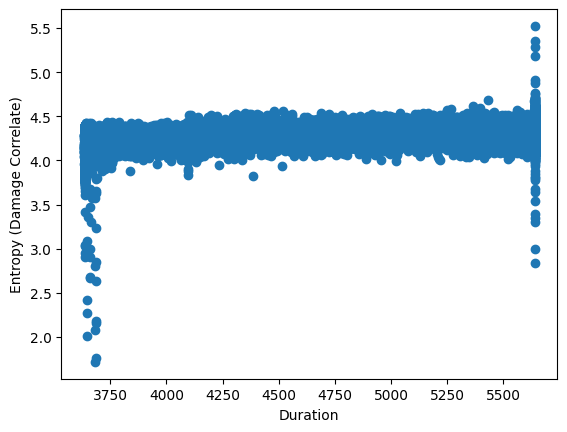

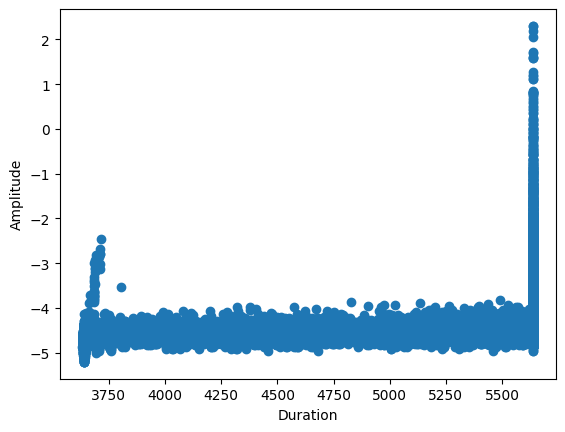

Text(0, 0.5, 'Entropy (Damage Correlate)')

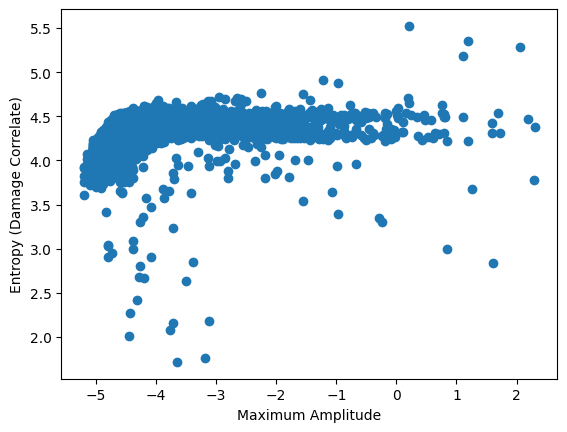

In [ ]:
plt.scatter(a,e)
plt.xlabel("Duration")
plt.ylabel("Entropy (Damage Correlate)")

plt.show()
plt.scatter(a,np.log(amp))
plt.xlabel("Duration")
plt.ylabel("Amplitude")
plt.show()
plt.scatter(np.log(amp),e)
plt.xlabel("Maximum Amplitude")
plt.ylabel("Entropy (Damage Correlate)")


In [ ]:
import os
import matplotlib.pyplot as plt
import scipy.signal as sig
import numpy as np

class Dataset:
    def __init__(self):
        self.hits = []
    def add_hit(self, fname):
        hit = Hit()
        hit.read_text(fname)
        self.hits.append(hit)
        return self.hits[-1]
    def add_hits(self, folder):
        for file in os.listdir(folder):
            f = os.path.join(folder, file)
            self.add_hit(f)
            if len(self.hits) % 200 == 0:
                print(len(self.hits))


class Hit:
    "represents a waveform with a fixed number of voltage values over time"
    def __init__(self, fname=None, waveform=None):
        self.file_name = fname
        self.start_time = None
        self.waveform = waveform
        self.entropy = None
        self.ie_outlier = None
        self.sample_interval = None
        self.spectrogram = None
    
    def ID(self):
        return self.file_name.split("\\")[-1].split(".")[0]
    def write_wave(self, folder):
        if not folder[-1] == "\\":
            folder = folder + "\\"
        f =  folder + self.ID()
        np.save(f,self.waveform)
    
    def write_spect(self, folder):
        if not folder[-1] == "\\":
            folder = folder + "\\"
        f =  folder + self.ID()
        np.save(f,self.spectrogram)

    def read_spect(self, folder):
        pass

    def read_text(self, fname=None):
        if fname is not None:
            self.file_name = fname
        with open(self.file_name, mode='r') as f:
            txt = f.readlines()
        for ind, line in enumerate(txt):
            if "TIME OF TEST:" in line:
                self.start_time = float(line.split(": ")[1])
            if "SAMPLE INTERVAL (Seconds):" in line:
                self.sample_interval = float(line.split(": ")[1])
            if line=="\n":
                self.waveform = []
                break
        else:
            print(fname)
            raise ValueError("Expected blank line not found in waveform datafile")
        for line in txt[ind+1:]:
            self.waveform.append(float(line))
    def spect(self, binsize, sample_rate=1, plot=False):
        pass

def spect(wave, binsize, sample_rate=1):
    return sig.spectrogram(np.array(wave), nperseg=binsize, fs=sample_rate)[2]

In [ ]:
import tensorflow as tf
from statistics import stdev
import time
from tensorflow.keras import layers, models

In [ ]:
print("starting")
folder = "Waveform1"
test = Dataset()
t1 = time.time()
test.add_hits(f"Waveform1")
t2 = time.time()
print("imported", t2-t1)

In [ ]:
for h in test.hits:
    h.spectrogram = spect(h.waveform, 120, sample_rate=1)
    h.entropy = entropy(h.waveform)
t3 = time.time()
print("spectrogrammed", t3-t2)


In [ ]:
print(len(test.hits))

In [ ]:

for h in test.hits:
    #f = "SG\\" + h.file_name.split("\\")[-1].split(".")[0]
    f2 = "waves\\" + h.file_name.split("\\")[-1].split(".")[0]

    #np.save(f,h.spectrogram)
    #np.save(f2,h.waveform)
        

In [ ]:
w0 = np.array([h.spectrogram for h in test.hits])
w1 = np.sqrt(w0)
std = np.std(w1.flatten())
mean = np.mean(w1)
w = (w1- mean) / (10*std)
ie = np.array([h.entropy for h in test.hits])
y = np.array([np.array(o+1) for o in outlier(ie)])

print("done")

In [ ]:
import os
import numpy as np
specs = []
for file in os.listdir("SG")[0:-1:5]:
    specs.append(np.load("SG\\"+file))

print(len(specs))

In [ ]:
np.average(specs)
np.std(specs)
np.max(specs)


In [ ]:

np.random.seed(42)
filt = np.random.rand(len(specs))
sp_train = []; sp_val = []
for i in range(len(specs)):
    if filt[i]<0.8:
        sp_train.append(specs[i])
    else:
        sp_val.append(specs[i])

sp_train = np.array(sp_train)
sp_val = np.array(sp_val)